## [Example: Toy Mixture Model With Discrete Enumeration](http://pyro.ai/examples/toy_mixture_model_discrete_enumeration.html#example-toy-mixture-model-with-discrete-enumeration)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.distributions import constraints
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.beta import Beta
from tqdm import tqdm

In [3]:
import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.optim
from pyro.ops.indexing import Vindex

In [4]:
def generate_data(num_obs):
    prior = {
        'A': torch.tensor([1.0,10.0]),
        'B': torch.tensor([[10.0,1.0], [1.0, 10.0]]),
        'C': torch.tensor([[10.0,1.0],[1.0,10.6]])
    }

    CPDs = {
        'p_A': Beta(prior['A'][0], prior['A'][1]).sample(),
        'p_B': Beta(prior['B'][:, 0], prior['B'][:, 1]).sample(),
        'p_C': Beta(prior['C'][:,0], prior['C'][:, 1]).sample()
    }

    data = {'A': Bernoulli(torch.ones(num_obs)*CPDs['p_A']).sample()}
    
    data['B'] = Bernoulli(
        torch.gather(CPDs['p_B'], 0, data['A'].type(torch.long))
    ).sample()
    
    data['C'] = Bernoulli(
        torch.gather(CPDs['p_C'], 0, data['B'].type(torch.long))
    ).sample()
    return prior, CPDs, data


In [5]:
t = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
torch.gather(t, dim=1, index=torch.tensor([[0,1],[2,0]]))

tensor([[1, 2],
        [6, 4]])

In [6]:
generate_data(5)

({'A': tensor([ 1., 10.]),
  'B': tensor([[10.,  1.],
          [ 1., 10.]]),
  'C': tensor([[10.0000,  1.0000],
          [ 1.0000, 10.6000]])},
 {'p_A': tensor(0.0213),
  'p_B': tensor([0.8664, 0.1402]),
  'p_C': tensor([0.9801, 0.0681])},
 {'A': tensor([0., 0., 0., 0., 0.]),
  'B': tensor([1., 1., 0., 1., 1.]),
  'C': tensor([0., 0., 1., 0., 0.])})

In [20]:
@pyro.infer.config_enumerate
def model(prior, obs, num_obs):
    p_A = pyro.sample('p_A', dist.Beta(1,1))
    p_B = pyro.sample('p_B', dist.Beta(torch.ones(2), torch.ones(2)).to_event(1))
    p_C = pyro.sample('p_C', dist.Beta(torch.ones(2), torch.ones(2)).to_event(1))

    with pyro.plate('data_plate', num_obs):
        A = pyro.sample('A', dist.Bernoulli(p_A.expand(num_obs)), obs=obs['A'])
        B = pyro.sample(
            'B',
            dist.Bernoulli(Vindex(p_B)[A.type(torch.long)]),
            infer = {'enumerate': 'parallel'}
        )
        pyro.sample('C', dist.Bernoulli(Vindex(p_C)[B.type(torch.long)]), obs=obs['C'])

In [8]:
def guide(prior, obs, num_obs):
    a = pyro.param('a', prior['A'], constraint=constraints.positive)
    pyro.sample('p_A', dist.Beta(a[0], a[1]))

    b = pyro.param('b', prior['B'], constraint=constraints.positive)
    pyro.sample('p_B', dist.Beta(b[:,0], b[:,1]).to_event(1))

    c = pyro.param('c', prior['C'], constraint=constraints.positive)
    pyro.sample('p_C', dist.Beta(c[:,0], c[:, 1]).to_event(1))
    

In [30]:
def train(prior, data, num_steps, num_obs):
    pyro.clear_param_store()
    loss_fn = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1) # only one plate in the model
    svi = pyro.infer.SVI(model, guide, pyro.optim.Adam({'lr':0.01}), loss=loss_fn)

    losses = []

    for _ in tqdm(range(num_steps)):
        loss = svi.step(prior, data, num_obs)
        losses.append(loss)

    plt.figure()
    plt.plot(losses)
    plt.show()

    posterior_params = {
        k: np.array(v.data) for k, v in pyro.get_param_store().items()
    }
    posterior_params['a'] = posterior_params['a'][None, :]
    return posterior_params

___

In [31]:
num_obs = 10000
priors, cpds, data = generate_data(num_obs)

100%|██████████| 4000/4000 [00:43<00:00, 91.60it/s]


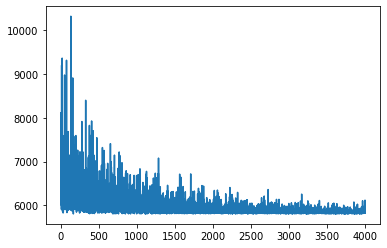

{'a': array([[ 16.860266, 298.33112 ]], dtype=float32),
 'b': array([[156.92253  ,  14.147445 ],
        [  7.4446764,  68.86691  ]], dtype=float32),
 'c': array([[ 60.25509 ,   7.22736 ],
        [  9.655925, 154.02142 ]], dtype=float32)}

In [32]:
train(priors, data, num_steps=4000, num_obs=num_obs)

In [34]:
cpds

{'p_A': tensor(0.0556),
 'p_B': tensor([0.9618, 0.1466]),
 'p_C': tensor([0.9397, 0.0831])}